                                                                                               Hailemariam A. Tekile,
                                                                                               March 05, 2023

# Gurobi in Python: Solve an integer linear programming (or binary integer programming) to find the 5-regular graph with 22 vertices, diameter 2 and degree 5.
                                                          

 Let $N=\{1,\ldots,22\}$ be the nodes, and let $P=\{i \in N,j \in N:i<j\}$ be the set of node pairs. For $(i,j) \in P$, let binary decision variable $X_{i,j}$ indicate whether $(i,j)$ is an edge. For $(i,j) \in P$ and $k \in N \setminus \{i,j\}$, let binary decision variable $Y_{i,j,k}$ indicate whether $k$ is a common neighbor of $i$ and $j$. For $(i,j) \in P$ let binary decision variable $SLACK_{i,j}$ be a slack variable.
 
\begin{align}
\min{\sum_{(i,j) \in P}{SLACK_{i,j}}} \hspace{5cm}\\
\sum_{(i,j) \in P: k \in \{i,j\}}{X_{i,j} =5} \hspace{3cm} \text{ for } k \in N\\
X_{i,j}+\sum_{k \in N \setminus \{i,j\}}{Y_{i,j,k}} + SLACK_{i,j} \geq 1 \hspace{1cm} \text{ for } (i,j) \in P\\
 Y_{i,j,k} \leq [i<k]X_{i,k}+[k<i]X_{k,i} \hspace{2cm} \text{ for $(i,j)$} \in P \text{ and }k \in N \setminus \{i,j\}\\
 Y_{i,j,k} \leq [j<k]X_{j,k}+[k<j]X_{k,j} \hspace{2cm} \text{ for $(i,j)$} \in P \text{ and }k \in N \setminus \{i,j\}
\end{align}
Constraint (2) enforces $5$-regularity. Constraint (3) enforces diameter 2. Constraints (4) and (5) enforce that $Y_{i,j,k}=1$ implies $k$ is a neighbor of $i$ and $j$, respectively. A desired graph exists if and only if the integer linear program has a solution with $SLACK_{i,j} = 0\, \forall (i, j) \in P$.


Reference: Szádoczki, Z., Bozóki, S., & Tekile, H. A. (2022). Filling in pattern designs for incomplete pairwise comparison matrices:(quasi-) regular graphs with minimal diameter. Omega, 107, 102557.

In [6]:
#import modules
import gurobipy as gp
from gurobipy import GRB

# Number of vertices/Nodes
n = 22
#Set of vertices/nodes
NODES = range(1, n+1)

# Degree is 5 (to find 5-regular graph)
degree = {k: 5 for k in NODES}
NODE_PAIRS = [(i, j) for i in NODES for j in NODES if i < j]

# Define the optimization model
model = gp.Model();

# Define the decision variables
X = model.addVars(NODE_PAIRS, vtype=gp.GRB.BINARY, name="X")
Y = model.addVars(NODE_PAIRS, NODES, vtype=gp.GRB.BINARY, name="Y")

# Define slack variables
Slack = model.addVars(NODE_PAIRS, name="Slack", lb=0)

# Add constraints:
#Constraint 1 (named as DegreeCon) enforces 5-regularity
DegreeCon = model.addConstrs((gp.quicksum(X[i, j] for i, j in NODE_PAIRS if k in (i, j)) == degree[k] for k in NODES),
                             name="DegreeCon") 
#Constraint 2 (named as DiameterTwo) enforces diameter 2
DiameterTwo = model.addConstrs((X[i, j] + gp.quicksum(Y[i, j, k] for k in NODES if k not in (i, j)) + Slack[i, j] >= 1
                                for i, j in NODE_PAIRS), name="DiameterTwo")
#Constraint 3 (named as CommonNeighbor1) enforces that Y[i,j,k] = 1 implies k is a neighbor of i and j
CommonNeighbor1 = model.addConstrs((Y[i, j, k] <= (X[i, k] if (i, k) in NODE_PAIRS else X[k, i])
                                    for i, j in NODE_PAIRS for k in NODES if k not in (i, j)),
                                   name="CommonNeighbor1")
#Constraint 4 (named as CommonNeighbor2) enforces that Y[i,j,k] = 1 implies k is a neighbor of i and j
CommonNeighbor2 = model.addConstrs((Y[i, j, k] <= (X[j, k] if (j, k) in NODE_PAIRS else X[k, j])
                                    for i, j in NODE_PAIRS for k in NODES if k not in (i, j)),
                                   name="CommonNeighbor2")

# Set the objective function
model.setObjective(gp.quicksum(Slack[i, j] for i, j in NODE_PAIRS), sense=gp.GRB.MINIMIZE)

# Optimize the model
model.optimize()

if model.status == gp.GRB.OPTIMAL:
    #X_sol = {(i, j): X[i, j].x for i, j in NODE_PAIRS}
    #Y_sol = {(i, j, k): Y[i, j, k].x for i, j in NODE_PAIRS for k in NODES if k not in (i, j)}
    EDGES = {(i, j) for i, j in NODE_PAIRS if X[i, j].x > 0.5}
    
    # Print the optimal solutions/EDGES
    #print("X_sol =", X_sol)
    #print("Y_sol =", Y_sol)
    print("EDGES =", EDGES)


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9493 rows, 5544 columns and 24024 nonzeros
Model fingerprint: 0x9d7ee588
Variable types: 231 continuous, 5313 integer (5313 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 176.0000000
Presolve removed 0 rows and 462 columns
Presolve time: 0.07s
Presolved: 9493 rows, 5082 columns, 24024 nonzeros
Variable types: 0 continuous, 5082 integer (5082 binary)
Found heuristic solution: objective 51.0000000

Root relaxation: objective 0.000000e+00, 7134 iterations, 1.05 seconds (2.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

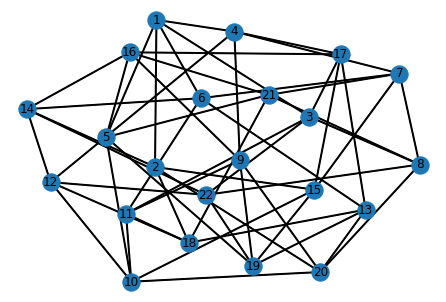

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add the nodes
G.add_nodes_from(NODES)

# Add the edges
G.add_edges_from(EDGES)

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edges(G, pos=pos, edgelist=EDGES, width=2)
plt.show()


To check: A desired graph exists if and only if the integer linear programming has a solution with $SLACK_{i,j} = 0\, \forall (i, j) \in P$

In [10]:
print(Slack)

{(1, 2): <gurobi.Var Slack[1,2] (value 0.0)>, (1, 3): <gurobi.Var Slack[1,3] (value 0.0)>, (1, 4): <gurobi.Var Slack[1,4] (value 0.0)>, (1, 5): <gurobi.Var Slack[1,5] (value 0.0)>, (1, 6): <gurobi.Var Slack[1,6] (value 0.0)>, (1, 7): <gurobi.Var Slack[1,7] (value -0.0)>, (1, 8): <gurobi.Var Slack[1,8] (value -0.0)>, (1, 9): <gurobi.Var Slack[1,9] (value -0.0)>, (1, 10): <gurobi.Var Slack[1,10] (value -0.0)>, (1, 11): <gurobi.Var Slack[1,11] (value -0.0)>, (1, 12): <gurobi.Var Slack[1,12] (value -0.0)>, (1, 13): <gurobi.Var Slack[1,13] (value -0.0)>, (1, 14): <gurobi.Var Slack[1,14] (value -0.0)>, (1, 15): <gurobi.Var Slack[1,15] (value -0.0)>, (1, 16): <gurobi.Var Slack[1,16] (value -0.0)>, (1, 17): <gurobi.Var Slack[1,17] (value -0.0)>, (1, 18): <gurobi.Var Slack[1,18] (value -0.0)>, (1, 19): <gurobi.Var Slack[1,19] (value -0.0)>, (1, 20): <gurobi.Var Slack[1,20] (value -0.0)>, (1, 21): <gurobi.Var Slack[1,21] (value -0.0)>, (1, 22): <gurobi.Var Slack[1,22] (value -0.0)>, (2, 3): <gur